In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config

from runner import (
    run_vsem_experiment, 
    plot_coverage,
    plot_coverage_single_rep,
)

import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

config.update("jax_enable_x64", True)


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## VSEM Experiment 1

In [2]:
rng = np.random.default_rng(6435)
n_design = 15
n_reps = 15

tests, metrics, failed = run_vsem_experiment(rng, n_design, n_reps)

Replication 1


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 63.113221
         Iterations: 78
         Function evaluations: 138
         Gradient evaluations: 127
Replication 2
Optimization terminated successfully.
         Current function value: 77.345067
         Iterations: 103
         Function evaluations: 154
         Gradient evaluations: 151
Replication 3
Optimization terminated successfully.
         Current function value: 65.610637
         Iterations: 97
         Function evaluations: 107
         Gradient evaluations: 107
Replication 4
Optimization terminated successfully.
         Current function value: 66.847822
         Iterations: 82
         Function evaluations: 91
         Gradient evaluations: 91
Replication 5
Optimization terminated successfully.
         Current function value: 49.530963
         Iterations: 81
         Function evaluations: 95
         Gradient evaluations: 95
Replication 6


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 56.820711
         Iterations: 111
         Function evaluations: 188
         Gradient evaluations: 175
Replication 7


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 50.054026
         Iterations: 52
         Function evaluations: 128
         Gradient evaluations: 117
Replication 8


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 39.665286
         Iterations: 79
         Function evaluations: 125
         Gradient evaluations: 115
Replication 9
Optimization terminated successfully.
         Current function value: 33.317048
         Iterations: 59
         Function evaluations: 76
         Gradient evaluations: 76
Replication 10


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 54.941285
         Iterations: 72
         Function evaluations: 127
         Gradient evaluations: 117
Replication 11


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 46.961765
         Iterations: 74
         Function evaluations: 125
         Gradient evaluations: 111
Replication 12


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 68.569615
         Iterations: 62
         Function evaluations: 106
         Gradient evaluations: 95
Replication 13


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.264772
         Iterations: 60
         Function evaluations: 132
         Gradient evaluations: 120
Replication 14
Optimization terminated successfully.
         Current function value: 71.114903
         Iterations: 88
         Function evaluations: 94
         Gradient evaluations: 94
Replication 15


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 52.316286
         Iterations: 101
         Function evaluations: 247
         Gradient evaluations: 234
Number of failed iterations: 0


In [3]:
# Exclude failed runs
tests = [x for i, x in enumerate(tests) if i not in failed]
metrics = [x for i, x in enumerate(metrics) if i not in failed]

print(f'Number of replicates remaining: {len(tests)}')

Number of replicates remaining: 15


In [ ]:
import numpy as np

def _logsumexp(logv):
    # stable log-sum-exp
    m = np.max(logv)
    if not np.isfinite(m):
        # If m == -inf, all entries are -inf -> sum is 0; return -inf
        return -np.inf
    return m + np.log(np.sum(np.exp(logv - m)))

def coverage_curve(
    logp_true,
    logp_approx,
    alphas=None,
    *,
    cell_area=None,
):
    """
    Compute coverage curve on a discrete grid.

    Parameters
    ----------
    logp_true : array_like
        log of true probability mass or log density evaluated at grid points.
    logp_approx : array_like
        log of approximate probability mass or log density at same grid.
    alphas : array_like or None
        nominal HPD mass levels to evaluate (values between 0 and 1). If None,
        defaults to np.linspace(0.01, 0.99, 99).
    cell_area : float or None
        If provided, the inputs are treated as log *densities* on an evenly
        spaced grid and will be converted to log *masses* by adding log(cell_area).
        If None, the function treats the exponentiated values as already
        representing (unnormalized) masses and normalizes them.

    Returns
    -------
    alphas, coverage, calib_error
      alphas: array
      coverage: array same length — true mass inside approx HPD(alpha)
      calib_error: mean absolute deviation between coverage and nominal alpha
    """
    if alphas is None:
        alphas = np.linspace(0.01, 0.99, 99)
    alphas = np.asarray(alphas)
    if np.any(alphas < 0) or np.any(alphas > 1):
        raise ValueError("alphas must lie in [0,1]")

    # Flatten inputs and check shapes
    logp_t = np.asarray(logp_true).ravel()
    logp_a = np.asarray(logp_approx).ravel()
    if logp_t.shape != logp_a.shape:
        raise ValueError("logp_true and logp_approx must have the same number of elements")

    # If densities -> convert to masses by adding log(cell_area)
    if cell_area is not None:
        if cell_area <= 0:
            raise ValueError("cell_area must be positive")
        log_cell_area = np.log(cell_area)
        logp_t = logp_t + log_cell_area
        logp_a = logp_a + log_cell_area

    # Stabilize and normalize to get proper mass vectors that sum to 1
    lse_a = _logsumexp(logp_a)
    lse_t = _logsumexp(logp_t)

    if not np.isfinite(lse_a):
        # all -inf -> zero mass (degenerate). In that case, approximate ordering is meaningless.
        raise ValueError("approximate log-probabilities are all -inf or non-finite")
    if not np.isfinite(lse_t):
        raise ValueError("true log-probabilities are all -inf or non-finite")

    # compute normalized masses (in linear domain) in a numerically stable manner
    p_a = np.exp(logp_a - lse_a)
    p_t = np.exp(logp_t - lse_t)

    # Now p_a.sum() == 1 and p_t.sum() == 1 (up to rounding)
    # Sort by approx descending
    order = np.argsort(logp_a)[::-1]   # sorting by logp_a is equivalent to sorting by p_a
    approx_cum = np.cumsum(p_a[order])

    coverage = np.empty_like(alphas, dtype=float)
    n = p_a.size

    for i, alpha in enumerate(alphas):
        if alpha <= 0:
            coverage[i] = 0.0
            continue
        if alpha >= 1:
            coverage[i] = 1.0
            continue
        k = np.searchsorted(approx_cum, alpha, side='left')
        # if searchsorted returns n, include all indices
        if k >= n:
            idxs = order
        else:
            idxs = order[: k + 1 ]   # include up to index k (first index where cum >= alpha)
        coverage[i] = float(np.sum(p_t[idxs]))

    calib_error = float(np.mean(np.abs(coverage - alphas)))
    return alphas, coverage, calib_error


In [4]:
# Assumed constrant across all replications
probs = metrics[0]['alphas']

n_reps = len(tests)
n_probs = len(probs)
mean_coverage = np.empty((n_reps, n_probs))
eup_coverage = np.empty((n_reps, n_probs))
ep_coverage = np.empty((n_reps, n_probs))

# assemble arrays of coverage stats
for i, results in enumerate(metrics):
    mean, eup, ep = results['coverage']
    mean_coverage[i,:] = mean
    eup_coverage[i,:] = eup
    ep_coverage[i,:] = ep

In [21]:
q_min = 0.4
q_max = 0.85

# summarize distribution over replications
mean_m = np.median(mean_coverage, axis=0)
eup_m = np.median(eup_coverage, axis=0)
ep_m = np.median(ep_coverage, axis=0)
mean_q = np.quantile(mean_coverage, q=[q_min, q_max], axis=0)
eup_q = np.quantile(eup_coverage, q=[q_min, q_max], axis=0)
ep_q = np.quantile(ep_coverage, q=[q_min, q_max], axis=0)

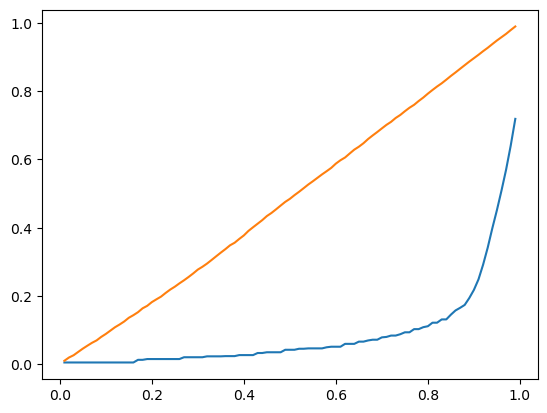

In [22]:
plt.plot(probs, mean_q[0])
plt.plot(probs, mean_q[1])
plt.show()

In [ ]:
def plot_coverage(tests: list[VSEMTest], 
                  metrics: list, 
                  q_min: float = 0.05, 
                  q_max: float = 0.95, 
                  figsize=(12, 4)):
    """
    The first two arguments are those returned by `run_vsem_experiment()`.
    Assumes the same coverage probabilities were used for all replications
    within the experiment.
    """

    # Assumed constrant across all replications
    probs = metrics[0]['alphas']

    n_reps = len(tests)
    n_probs = len(probs)
    mean_coverage = np.empty((n_reps, n_probs))
    eup_coverage = np.empty((n_reps, n_probs))
    ep_coverage = np.empty((n_reps, n_probs))

    # assemble arrays of coverage stats
    for i, results in enumerate(metrics):
        mean, eup, ep = results['coverage']
        mean_coverage[i,:] = mean
        eup_coverage[i,:] = eup
        ep_coverage[i,:] = ep

    # summarize distribution over replications
    mean_m = np.median(mean_coverage, axis=0)
    eup_m = np.median(eup_coverage, axis=0)
    ep_m = np.median(ep_coverage, axis=0)
    mean_q = np.quantile(mean_coverage, q=[q_min, q_max], axis=0)
    eup_q = np.quantile(eup_coverage, q=[q_min, q_max], axis=0)
    ep_q = np.quantile(ep_coverage, q=[q_min, q_max], axis=0)

    meds = [mean_m, eup_m, ep_m]
    qs = [mean_q, eup_q, ep_q]
    labels = ['mean', 'eup', 'ep']
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    axs = axs.reshape(-1)
    n_plots = len(axs)

    for i in range(n_plots):
        ax = axs[i]
        q = qs[i]
        med = meds[i]
        label = labels[i]

        ax.fill_between(probs, q[0,:], q[1,:], alpha=0.4)
        ax.plot(probs, med)
        ax.set_title(label)
        ax.set_xlabel('Nominal Coverage')
        ax.set_ylabel('Actual Coverage')

        # Add line y = x
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        y = x
        ax.plot(x, y, color="red", linestyle="--")
        ax.legend()

    plt.close(fig)
    return fig, axs


In [ ]:
qmin = 0.1
qmax = 0.9

fig, ax = plot_coverage(tests, metrics, q_min=qmin, q_max=qmax)
fig.savefig(f"out/coverage1_{qmin}_{qmax}.png")
display(fig)

### Looking at one of the replicates

In [ ]:
rep_idx = 0

test = tests[rep_idx]
metric = metrics[rep_idx]
inv_prob = test.inv_prob

In [ ]:
inv_prob.likelihood.plot_driver()
plt.close()

In [ ]:
inv_prob.likelihood.plot_ground_truth()

In [ ]:
# GP predictions

fig_gp, axs_gp = test.plot_gp_pred(conditional=True, pred_type='pred', markersize=8)
fig_gp.savefig(f'out/gp_pred_rep{rep_idx}.png')
display(fig_gp)
plt.close()

In [ ]:
# Comparing posteriors
fig_log, axs_log = test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                  pred_type='pred', nrows=2, figsize=(10,8))
fig, axs = test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                          pred_type='pred', nrows=2, figsize=(10,8))

fig_log.savefig(f'out/post_comparison_logscale_rep{rep_idx}.png')
fig.savefig(f'out/post_comparison_rep{rep_idx}.png')
display(fig_log)
display(fig)
plt.close()

In [ ]:
# Surrogate bias 

fig_bias, ax_bias = test.plot_gp_bias(conditional=True, pred_type='pred')

fig_bias.savefig(f'out/gp_bias_rep{rep_idx}.png')
display(fig_bias)
plt.close()

In [ ]:
# Coverage plot

coverage_list = metric['coverage']
alphas = metric['alphas']

fig = plot_coverage_single_rep(alphas, coverage_list, labels=['mean', 'eup', 'ep'])
fig.savefig(f'out/coverage_rep{rep_idx}.png')
display(fig)

In [ ]:
# Sample exact posterior
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=20000)

display(trace_plot)
plt.close()

In [ ]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*inv_prob.likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()
plt.close()

In [ ]:
"""
log_dens_obs = lambda pred_obs: vsem_test.inv_prob.likelihood._likelihood_rv.log_p(pred_obs)
gpwrapped = gpjaxGP(vsem_test.gp_posterior, vsem_test.design, rng)
u_init = vsem_test.inv_prob.prior.sample()

rkpcn = RandomKernelPCNSampler(log_density=log_dens_obs,
                               gp=gpwrapped,
                               u_init=u_init,
                               u_prop_cov=proposal_cov,
                               pcn_cor=0.99,
                               rng=rng)

rkpcn.sample(num_steps=100)


n_samp = len(rkpcn.trace)
u_samp = np.empty((n_samp, prior.dim))
fu_samp = np.empty(n_samp)

for i, state in enumerate(rkpcn.trace):
    u_samp[i] = state.primary['u']
    fu_samp[i] = state.primary['fu'].squeeze()
"""